In [8]:
# import torch
# torch.cuda.is_available()

In [9]:
# import torch
# torch.zeros(1).cuda()

In [10]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import Bidirectional, Flatten
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

## Fetch Dataset

In [12]:
path = '../Dataset/'

In [13]:
df = pd.read_csv(path+'KolkataDataset_named.csv')
df.dropna(inplace=True)
df.rename(columns = {'label':'classLabel'}, inplace = True)

### Visualize Dataset

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8327 entries, 0 to 8328
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8327 non-null   int64 
 1   tweet       8327 non-null   object
 2   classLabel  8327 non-null   object
dtypes: int64(1), object(2)
memory usage: 260.2+ KB


In [15]:
df.classLabel.value_counts()

City program                2150
Roads related congestion    1811
Vehicle breakdown           1636
Closed Avenue               1375
Others                      1101
Road blockage                254
Name: classLabel, dtype: int64

[Text(0, 0, 'Vehicle breakdown'),
 Text(1, 0, 'Roads related congestion'),
 Text(2, 0, 'Others'),
 Text(3, 0, 'City program'),
 Text(4, 0, 'Closed Avenue'),
 Text(5, 0, 'Road blockage')]

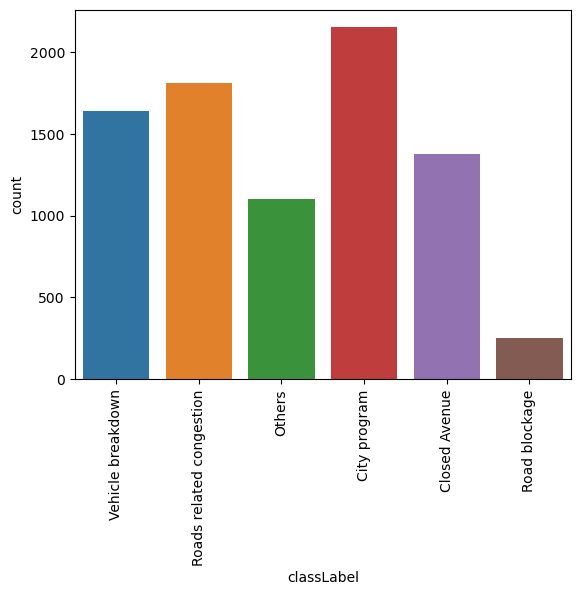

In [16]:
s = sns.countplot(x='classLabel',data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)

## Dataset Preprocessing

### Data Cleaning : Stemming and Remove stop words

In [17]:
def print_plot(index):
    example = df[df.index == index][['tweet', 'classLabel']].values[0]
    if len(example) > 0:
        print(example[0])
        print('classLabel:', example[1])

In [18]:
print_plot(10)
print_plot(100)

due religious program following roads closed traffic kalakar street kali krishna tagore street
classLabel: City program
sudden breakdown vehicle nd hooghly bridge near bifurcation slowed traffic towards city
classLabel: Vehicle breakdown


In [19]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['tweet'] = df['tweet'].apply(clean_text)

In [20]:
df['tweet'] = df['tweet'].str.replace('\d+', '',regex=False)

In [21]:
print_plot(10)
print_plot(100)

due religious program following roads closed traffic kalakar street kali krishna tagore street
classLabel: City program
sudden breakdown vehicle nd hooghly bridge near bifurcation slowed traffic towards city
classLabel: Vehicle breakdown


### Transormation of X data into 'tokenized embedding'

In [22]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 25000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 120
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3377 unique tokens.


In [23]:
X = tokenizer.texts_to_sequences(df['tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
X

Shape of data tensor: (8327, 120)


array([[  0,   0,   0, ...,   4,  19,   5],
       [  0,   0,   0, ...,  21, 953,   5],
       [  0,   0,   0, ...,   2,   4,  19],
       ...,
       [  0,   0,   0, ..., 323, 344, 121],
       [  0,   0,   0, ...,   1,   3, 946],
       [  0,   0,   0, ...,   3, 120,  30]], dtype=int32)

### Transormation of Y data into 'Label Binarized '

In [24]:
Y = df['classLabel'].values
lb = LabelBinarizer()
y = lb.fit_transform(Y)
y

array([[0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]])

### Divide data into Train Test

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6661, 120) (6661, 6)
(1666, 120) (1666, 6)


## Defining BiLSTM Model

In [26]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [27]:
model = Sequential()
# model.add(SpatialDropout1D(0.2))
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Bidirectional(LSTM(EMBEDDING_DIM, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())


2023-07-07 11:09:22.299613: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 100)          2500000   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 6)                 1206      
                                                                 
Total params: 2,662,006
Trainable params: 2,662,006
Non-trainable params: 0
_________________________________________________________________
None


### Training of model on train Data

In [28]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import keras
st = time.time()
epochs = 50
batch_size = 32

checkpoint_path = '/home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Kolkata/cp-{epoch:03d}-{loss:0.4f}.hdf5'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor = 'loss',
    mode = min,
    save_best_only = True,
    verbose=1)

history = model.fit(X_train, Y_train, epochs = epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001),cp_callback])

et = time.time()
elapsed_time = et - st
print('Execution time: {:0.0f} seconds'.format(elapsed_time))

model.save('/home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Kolkata_model.h5')

import pickle
with open('/home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Kolkata_history', 'wb') as file_pi:
    pickle.dump(history, file_pi)



Epoch 1/50
188/188 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.8595
Epoch 1: loss improved from inf to 0.41473, saving model to /home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Kolkata/cp-001-0.4147.hdf5
188/188 [==============================] - 40s 179ms/step - loss: 0.4147 - accuracy: 0.8595 - val_loss: 0.0817 - val_accuracy: 0.9805
Epoch 2/50
188/188 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9761
Epoch 2: loss improved from 0.41473 to 0.10637, saving model to /home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Kolkata/cp-002-0.1064.hdf5
188/188 [==============================] - 32s 169ms/step - loss: 0.1064 - accuracy: 0.9761 - val_loss: 0.1078 - val_accuracy: 0.9715
Epoch 3/50
188/188 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.9831
Epoch 3: loss improved from 0.10637 to 0.06903, saving model to /home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Kolkata/cp-003-0.0690.

## Load Model and History

In [29]:
# from tensorflow import keras
# model = keras.models.load_model('/home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Merged_model.h5')
# import pickle
# with open(path+'merged_LSTM_history', "rb") as file_pi:
#   history = pickle.load(file_pi)

## Perform on Test Dataset




In [30]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}%'.format(accr[0],accr[1]*100))

53/53 [==============================] - 1s 23ms/step - loss: 0.1425 - accuracy: 0.9718
Test set
  Loss: 0.14
  Accuracy: 97.18%


## Result Analysis

### Plot Training Testing Accuracy and Loss

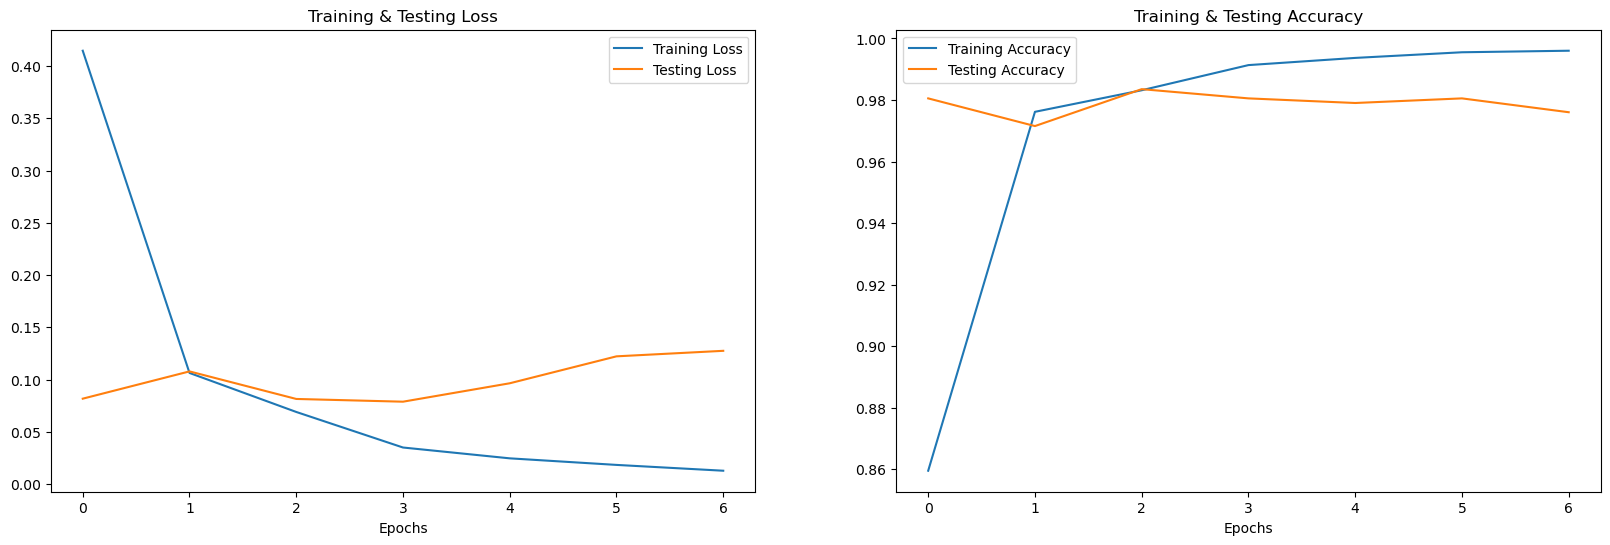

In [31]:
epochList = [i for i in range(len(history.history['loss']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochList , train_loss , label = 'Training Loss')
ax[0].plot(epochList , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochList , train_acc , label = 'Training Accuracy')
ax[1].plot(epochList , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

### Prediction of Model on Test Data

In [32]:
pred_test = model.predict(X_test)

53/53 [==============================] - 2s 24ms/step


In [33]:
y_pred = lb.inverse_transform(pred_test)
y_test = lb.inverse_transform(Y_test)

In [34]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[['City program' '442']
 ['Closed Avenue' '280']
 ['Others' '223']
 ['Road blockage' '53']
 ['Roads related congestion' '358']
 ['Vehicle breakdown' '310']]


### Plotting Confusion Matrix

<Figure size 3000x1000 with 0 Axes>

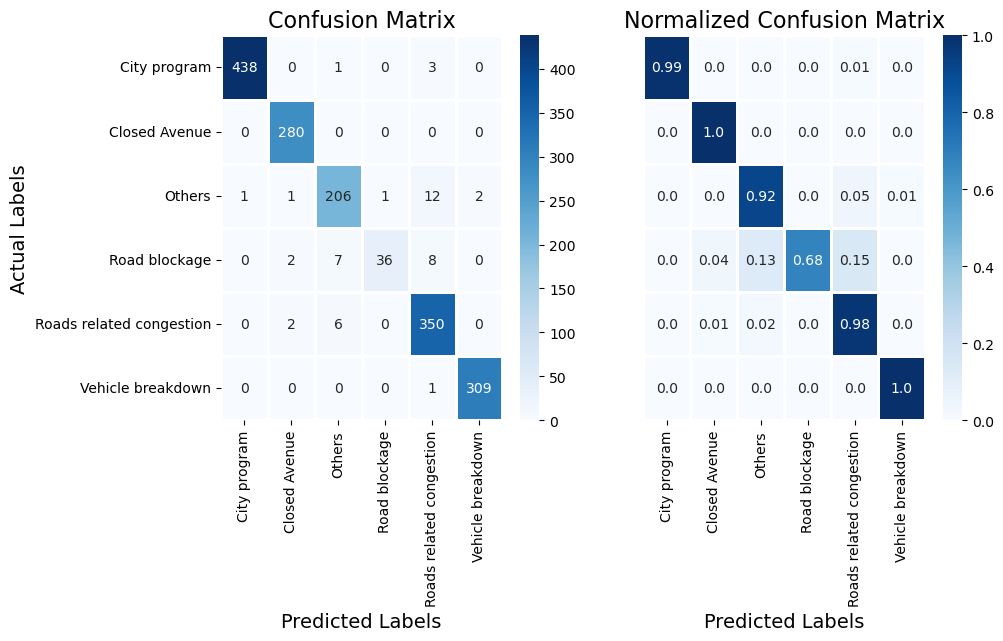

In [35]:
cm = confusion_matrix(y_test, y_pred)
cm1 = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
plt.figure(figsize = (30, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
cm1 = pd.DataFrame(cm1  , columns = [i for i in lb.classes_])

fig , ax = plt.subplots(1,2,figsize=(10,5))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=2, annot=True, fmt='',ax=ax[0])
ax[0].set_title('Confusion Matrix', size=16)
ax[0].set_xlabel('Predicted Labels', size=14)
ax[0].set_ylabel('Actual Labels', size=14)

sns.heatmap(cm1, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='',ax=ax[1],yticklabels=False)
ax[1].set_title('Normalized Confusion Matrix', size=16)
ax[1].set_xlabel('Predicted Labels', size=14)
plt.show()

In [36]:
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

            City program       1.00      0.99      0.99       442
           Closed Avenue       0.98      1.00      0.99       280
                  Others       0.94      0.92      0.93       223
           Road blockage       0.97      0.68      0.80        53
Roads related congestion       0.94      0.98      0.96       358
       Vehicle breakdown       0.99      1.00      1.00       310

                accuracy                           0.97      1666
               macro avg       0.97      0.93      0.94      1666
            weighted avg       0.97      0.97      0.97      1666



### Plotting Confusion Matrix

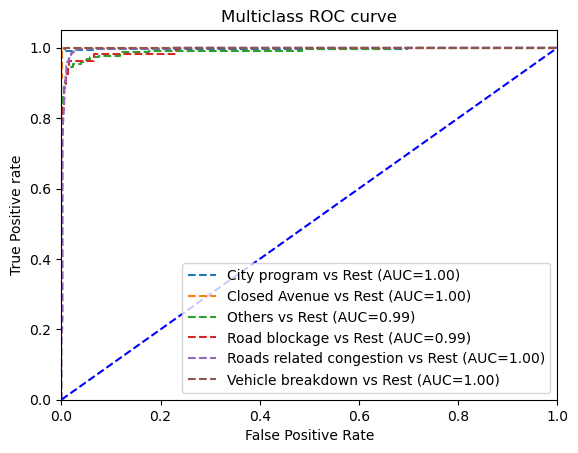

In [37]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve,auc

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

classes = lb.classes_

for i in range(len(classes)):
    # fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test[:,i], pred_test[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

## Calculating Evaluation Metric

In [38]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
precision, recall, fscore,_  = score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, pred_test,multi_class='ovr')
print('Accuracy, precision, recall, fscore, Roc-AUC')
print('{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}'.format(accuracy,precision,recall,fscore,roc_auc))

Accuracy, precision, recall, fscore, Roc-AUC
0.972,0.970,0.928,0.944,0.996


In [39]:
print('{},{:.0f},{:.4f},{:.4f}'.format(len(history.history['loss']),elapsed_time,train_acc[-1],test_acc[-1]))

7,231,0.9960,0.9760


## Test on Customized Tweet

In [40]:
lb.classes_

array(['City program', 'Closed Avenue', 'Others', 'Road blockage',
       'Roads related congestion', 'Vehicle breakdown'], dtype='<U24')

In [41]:
new_complaint = ['accident on 1 no street']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
print(pred)
print('Label: {}'.format(lb.classes_[np.argmax(pred)]))

1/1 [==============================] - 0s 179ms/step
[[3.7100919e-05 2.3029541e-05 4.6942907e-05 8.7109652e-07 9.9986947e-01
  2.2469796e-05]]
Label: Roads related congestion
